In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from bs4 import BeautifulSoup
import string,unicodedata
from sklearn.feature_extraction.text import CountVectorizer
from plotly.subplots import make_subplots
import plotly.graph_objects as go


In [2]:
df = pd.read_csv("/content/Ukraine Russia Reddit Scrape.csv")

In [3]:
df.head()

,body,category,communityName,createdAt,dataType,description,flair,html,id,isAd,...,scrapedAt,thumbnailUrl,title,upVoteRatio,upVotes,url,userIcon,userId,username,videoUrl
0,NaN,NaN,NaN,2019-05-08T23:00:43.000Z,user,End me,NaN,NaN,3qm6kus7,NaN,...,2024-06-18T15:20:22.942Z,NaN,NaN,NaN,NaN,https://www.reddit.com/user/yanguwu/,https://styles.redditmedia.com/t5_113me0/style...,NaN,yanguwu,NaN
1,URL: https://v.redd.it/6ns8h3jgcas81\nThumbnai...,NaN,r/PublicFreakout,2022-04-08T10:52:04.000Z,post,NaN,☠NSFL☠,NaN,t3_tz0sty,False,...,2024-06-18T15:20:26.344Z,nsfw,Ukraine: Russia just bombed a train station fi...,0.95,23628.0,https://www.reddit.com/r/PublicFreakout/commen...,NaN,t2_izish,MikeTheDude23,https://v.redd.it/6ns8h3jgcas81/DASH_480.mp4?s...
2,URL: https://v.redd.it/5o2e0h4lrthc1\nThumbnai...,NaN,r/CombatFootage,2024-02-10T21:20:37.000Z,post,NaN,Compilation,NaN,t3_1anqq5t,False,...,2024-06-18T15:20:28.430Z,https://external-preview.redd.it/dDhubHkwMGxyd...,Near death compilation Ukraine-Russia war 2022...,0.98,1778.0,https://www.reddit.com/r/CombatFootage/comment...,NaN,t2_6k471281,V2N0lay,https://v.redd.it/5o2e0h4lrthc1/DASH_480.mp4?s...
3,Please keep the [community guidelines](https:/...,CombatFootage,r/CombatFootage,2024-02-10T21:23:05.000Z,comment,NaN,NaN,"&lt;div class=""md""&gt;&lt;p&gt;Please keep the...",t1_kpu2qii,NaN,...,2024-06-18T15:20:28.490Z,NaN,NaN,NaN,1.0,https://www.reddit.com/r/CombatFootage/comment...,NaN,t2_6l4z3,AutoModerator,NaN
4,Butthole clinchers,CombatFootage,r/CombatFootage,2024-02-10T21:39:57.000Z,comment,NaN,NaN,"&lt;div class=""md""&gt;&lt;p&gt;Butthole clinch...",t1_kpu5d0u,NaN,...,2024-06-18T15:20:28.490Z,NaN,NaN,NaN,69.0,https://www.reddit.com/r/CombatFootage/comment...,NaN,t2_9jpgl,Schar83,NaN


Data Processing

In [4]:
df = df.iloc[:, :1]

In [5]:
df.head()

,body
0,NaN
1,URL: https://v.redd.it/6ns8h3jgcas81\nThumbnai...
2,URL: https://v.redd.it/5o2e0h4lrthc1\nThumbnai...
3,Please keep the [community guidelines](https:/...
4,Butthole clinchers


In [6]:
#Handling missing values
df = df.dropna()

In [7]:
df.head()

,body
1,URL: https://v.redd.it/6ns8h3jgcas81\nThumbnai...
2,URL: https://v.redd.it/5o2e0h4lrthc1\nThumbnai...
3,Please keep the [community guidelines](https:/...
4,Butthole clinchers
5,Great clips


In [8]:
mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot",
           "'cause": "because", "could've": "could have", "couldn't": "could not",
           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
           "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will",
           "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
           "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
           "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
           "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
           "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
           "might've": "might have","mightn't": "might not","mightn't've": "might not have",
           "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
           "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
           "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
           "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
           "she's": "she is", "should've": "should have", "shouldn't": "should not",
           "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
           "that'd": "that would", "that'd've": "that would have", "that's": "that is",
           "there'd": "there would", "there'd've": "there would have", "there's": "there is",
           "here's": "here is","they'd": "they would", "they'd've": "they would have",
           "they'll": "they will", "they'll've": "they will have", "they're": "they are",
           "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
           "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
           "we're": "we are", "we've": "we have", "weren't": "were not",
           "what'll": "what will", "what'll've": "what will have","what're": "what are",
           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
           "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
           "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
           "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
           "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
           "y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
           "you're": "you are", "you've": "you have" }

In [9]:
# Function to remove HTMl tags
def remove_html_tags(text):
  soup=BeautifulSoup(text, "html.parser")
  return soup.get_text()

# Assuming Processed Reddit is the column with HTML content
df['Clean body'] = df['body'].apply(remove_html_tags)

<ipython-input-9-34f7a9b0340c>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup=BeautifulSoup(text, "html.parser")


In [10]:
# Remove URLs and Special characters with Regular Expressions
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URL
    text = re.sub(r'\S*@\S*\s?', '', text)  # Remove mailboxes
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")]) #expanding chatwords and contracts clearing contractions
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'',text)
    return text

df['Clean body'] = df['Clean body'].apply(clean_text)

In [11]:
df['Clean body']

1                     URL \nThumbnail nsfw\nImages\n\t\n
2                         URL \nThumbnail \nImages\n\t\n
3      Please keep the community guidelines in mind w...
4                                     Butthole clinchers
5                                            Great clips
                             ...                        
496    Tldr the strong man is king So there is one st...
497    The weakest most pathetic people held off the ...
498    Russia was under Mongol rule longer than any o...
499             Ukraine wasnt a country back then but ok
500    Is that what youll say again in a year when Pu...
Name: Clean body, Length: 500, dtype: object

In [12]:
# Text preprocessing using NLTK or spaCy: word splitting, deletion of stop words, word shape reduction
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download the necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [13]:
stopwords = nltk.corpus.stopwords.words('english')
Clean_text = [word for word in df if word.lower() not in stopwords]


In [14]:
lemmatizer = WordNetLemmatizer()

In [15]:
# of pre-processed text
def preprocess_text(df):
    text = df.lower()
    words = df.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords]
    return ' '.join(words)

df['Processed body'] = df['Clean body'].apply(preprocess_text)
df['Processed body']

1                              URL Thumbnail nsfw Images
2                                   URL Thumbnail Images
3      Please keep community guideline mind using com...
4                                      Butthole clincher
5                                             Great clip
                             ...                        
496    Tldr strong man king So one strong asshole lea...
497    The weakest pathetic people held Mongol army N...
498    Russia Mongol rule longer nation The Chad Ukra...
499                        Ukraine wasnt country back ok
500          Is youll say year Putin leveled whole thing
Name: Processed body, Length: 500, dtype: object

In [16]:
df.to_csv('Processed_dataset_withsentiment.csv', index=False)

Keyword Extraction

In [17]:
# Extract keywords using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df['Processed body'])
tfidf

<500x729 sparse matrix of type '<class 'numpy.float64'>'
	with 3413 stored elements in Compressed Sparse Row format>

In [18]:
# Convert to array and get feature names (vocabulary)
feature_array = tfidf_vectorizer.get_feature_names_out()
tfidf_sorting = tfidf.toarray().argsort()[:, ::-1]

# Get the first N keywords of each document
n = 3
top_n_keywords = feature_array[tfidf_sorting][:,:n]
top_n_keywords

array([['thumbnail', 'images', 'url'],
       ['images', 'url', 'thumbnail'],
       ['bot', 'community', 'mind'],
       ...,
       ['mongol', 'longer', 'fight'],
       ['wasnt', 'country', 'ukraine'],
       ['youll', 'year', 'say']], dtype=object)

Sentiment Analysis

In [19]:
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [20]:
# Sentiment analysis using VADER
sid = SentimentIntensityAnalyzer()
df['Sentiments'] = df['Processed body'].apply(lambda x: sid.polarity_scores(x))

In [21]:
df['Sentiments']

1      {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
2      {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
3      {'neg': 0.0, 'neu': 0.813, 'pos': 0.187, 'comp...
4      {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
5      {'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'comp...
                             ...                        
496    {'neg': 0.169, 'neu': 0.608, 'pos': 0.223, 'co...
497    {'neg': 0.484, 'neu': 0.516, 'pos': 0.0, 'comp...
498    {'neg': 0.23, 'neu': 0.681, 'pos': 0.089, 'com...
499    {'neg': 0.321, 'neu': 0.679, 'pos': 0.0, 'comp...
500    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
Name: Sentiments, Length: 500, dtype: object

In [22]:
# VADER Sentiment analysis categorisation
def classify_sentiment_vader(scores):
    if scores['compound'] >= 0.05:
        return 'positive'
    elif scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['VADER Sentiment'] = df['Sentiments'].apply(classify_sentiment_vader)
df['VADER Sentiment']

1       neutral
2       neutral
3      positive
4       neutral
5      positive
         ...   
496    positive
497    negative
498    negative
499    negative
500     neutral
Name: VADER Sentiment, Length: 500, dtype: object

In [23]:
# Sentiment analysis using TextBlob (alternative)
df['TextBlob Sentiment'] = df['Processed body'].apply(lambda x: TextBlob(x).sentiment.polarity)
def classify_sentiment_textblob(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'

df['TextBlob Sentiment Category'] = df['TextBlob Sentiment'].apply(classify_sentiment_textblob)
df['TextBlob Sentiment Category']

1       neutral
2       neutral
3      positive
4       neutral
5      positive
         ...   
496    positive
497    negative
498     neutral
499    positive
500    positive
Name: TextBlob Sentiment Category, Length: 500, dtype: object

In [24]:
df.head()

,body,Clean body,Processed body,Sentiments,VADER Sentiment,TextBlob Sentiment,TextBlob Sentiment Category
1,URL: https://v.redd.it/6ns8h3jgcas81\nThumbnai...,URL \nThumbnail nsfw\nImages\n\t\n,URL Thumbnail nsfw Images,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,0.0,neutral
2,URL: https://v.redd.it/5o2e0h4lrthc1\nThumbnai...,URL \nThumbnail \nImages\n\t\n,URL Thumbnail Images,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,0.0,neutral
3,Please keep the [community guidelines](https:/...,Please keep the community guidelines in mind w...,Please keep community guideline mind using com...,"{'neg': 0.0, 'neu': 0.813, 'pos': 0.187, 'comp...",positive,0.1,positive
4,Butthole clinchers,Butthole clinchers,Butthole clincher,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,0.0,neutral
5,Great clips,Great clips,Great clip,"{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'comp...",positive,0.8,positive


In [25]:
df.to_csv('Processed_dataset_withsentiment.csv', index = False)

Topic Modeling

In [26]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [27]:
from collections import defaultdict
texts = [word_tokenize(doc) for doc in df['Processed body'] if word_tokenize(doc)]
# Remove very low-frequency words
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1] for text in texts]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

ldamodel = LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15)

In [28]:
topics = ldamodel.print_topics(num_words=2)
for topic in topics:
    print(topic)

(0, '0.038*"Putin" + 0.014*"NATO"')
(1, '0.034*"deleted" + 0.024*"Russian"')
(2, '0.030*"war" + 0.021*"I"')
(3, '0.058*"Russia" + 0.029*"Fuck"')
(4, '0.023*"shit" + 0.015*"Russian"')
(5, '0.057*"I" + 0.020*"like"')
(6, '0.036*"Russia" + 0.025*"people"')
(7, '0.033*"I" + 0.024*"Russia"')
(8, '0.021*"world" + 0.019*"like"')
(9, '0.017*"Russia" + 0.017*"war"')


In [29]:
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.038*"Putin" + 0.014*"NATO" + 0.014*"Ukraine" + 0.011*"go" + 0.011*"sure"')
(1, '0.034*"deleted" + 0.024*"Russian" + 0.024*"I" + 0.017*"civilian" + 0.015*"child"')
(2, '0.030*"war" + 0.021*"I" + 0.017*"would" + 0.013*"people" + 0.012*"world"')
(3, '0.058*"Russia" + 0.029*"Fuck" + 0.018*"like" + 0.018*"Putin" + 0.015*"war"')
(4, '0.023*"shit" + 0.015*"Russian" + 0.014*"provided" + 0.011*"back" + 0.010*"I"')
(5, '0.057*"I" + 0.020*"like" + 0.016*"video" + 0.010*"know" + 0.010*"see"')
(6, '0.036*"Russia" + 0.025*"people" + 0.025*"missile" + 0.024*"This" + 0.018*"You"')
(7, '0.033*"I" + 0.024*"Russia" + 0.015*"people" + 0.015*"right" + 0.014*"Ukraine"')
(8, '0.021*"world" + 0.019*"like" + 0.016*"war" + 0.016*"get" + 0.012*"dont"')
(9, '0.017*"Russia" + 0.017*"war" + 0.016*"fuck" + 0.015*"like" + 0.015*"say"')


In [30]:
pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 7.6 MB/s eta 0:00:00


In [31]:
# Lets visualize the topics
import pyLDAvis
from pyLDAvis.gensim import prepare

pyLDAvis.enable_notebook()
vis = prepare(ldamodel, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.021283  0.006326       1        1  20.560774
5     -0.019404  0.108465       2        1  12.468120
6     -0.003327 -0.077323       3        1  10.985918
2     -0.021212  0.020234       4        1   9.829649
1      0.166489  0.057636       5        1   9.738253
8      0.001561  0.096110       6        1   9.579008
3     -0.056280 -0.090466       7        1   8.296576
9     -0.162465  0.038424       8        1   8.063584
0      0.050550 -0.101549       9        1   5.843895
4      0.022804 -0.057856      10        1   4.634221, topic_info=           Term       Freq      Total Category  logprob  loglift
177      Russia  85.000000  85.000000  Default  30.0000  30.0000
343       Putin  34.000000  34.000000  Default  29.0000  29.0000
25      deleted  18.000000  18.000000  Default  28.0000  28.0000
568        Fuck  17.000000  17.000000  Default  27.0000  27.0000
99      missile  21.000000  21.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
43           go   1.550952  13.168754  Topic10  -4.9660   0.9327
425  everything   1.550819   6.621429  Topic10  -4.9661   1.6202
19          one   1.550811  20.408427  Topic10  -4.9661   0.4945
175        want   1.550810  21.108213  Topic10  -4.9661   0.4608
488        fuck   1.550499  16.276086  Topic10  -4.9663   0.7206

[604 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
146       2  0.412027      1
146       4  0.206014      1
146      10  0.412027      1
93        2  0.412578    100
93        5  0.206289    100
...     ...       ...    ...
37        2  0.109334  youre
37        3  0.109334  youre
37        6  0.218668  youre
37        7  0.109334  youre
37        9  0.218668  youre

[1229 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 6, 7, 3, 2, 9, 4, 10, 1, 5])

In [32]:
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,body,Clean body,Processed body,Sentiments,VADER Sentiment,TextBlob Sentiment,TextBlob Sentiment Category
1,URL: https://v.redd.it/6ns8h3jgcas81\nThumbnai...,URL \nThumbnail nsfw\nImages\n\t\n,URL Thumbnail nsfw Images,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,0.0,neutral
2,URL: https://v.redd.it/5o2e0h4lrthc1\nThumbnai...,URL \nThumbnail \nImages\n\t\n,URL Thumbnail Images,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,0.0,neutral
3,Please keep the [community guidelines](https:/...,Please keep the community guidelines in mind w...,Please keep community guideline mind using com...,"{'neg': 0.0, 'neu': 0.813, 'pos': 0.187, 'comp...",positive,0.1,positive
4,Butthole clinchers,Butthole clinchers,Butthole clincher,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,0.0,neutral
5,Great clips,Great clips,Great clip,"{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'comp...",positive,0.8,positive


In [36]:
len(df)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


498

In [37]:
df.drop(df.tail(2).index,
        inplace = True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
# Assume you already have a DataFrame containing documents, their most relevant topics, and sentiment scores
# We can get the most likely topic for each document through the LDA model
document_topics = [ldamodel[corpus[i]] for i in range(len(df))]
df['Dominant_Topic'] = [sorted(topics, key=lambda x: -x[1])[0][0] for topics in document_topics]

df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,body,Clean body,Processed body,Sentiments,VADER Sentiment,TextBlob Sentiment,TextBlob Sentiment Category,Dominant_Topic
1,URL: https://v.redd.it/6ns8h3jgcas81\nThumbnai...,URL \nThumbnail nsfw\nImages\n\t\n,URL Thumbnail nsfw Images,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,0.0,neutral,4
2,URL: https://v.redd.it/5o2e0h4lrthc1\nThumbnai...,URL \nThumbnail \nImages\n\t\n,URL Thumbnail Images,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,0.0,neutral,4
3,Please keep the [community guidelines](https:/...,Please keep the community guidelines in mind w...,Please keep community guideline mind using com...,"{'neg': 0.0, 'neu': 0.813, 'pos': 0.187, 'comp...",positive,0.1,positive,5
4,Butthole clinchers,Butthole clinchers,Butthole clincher,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,0.0,neutral,0
5,Great clips,Great clips,Great clip,"{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'comp...",positive,0.8,positive,4


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


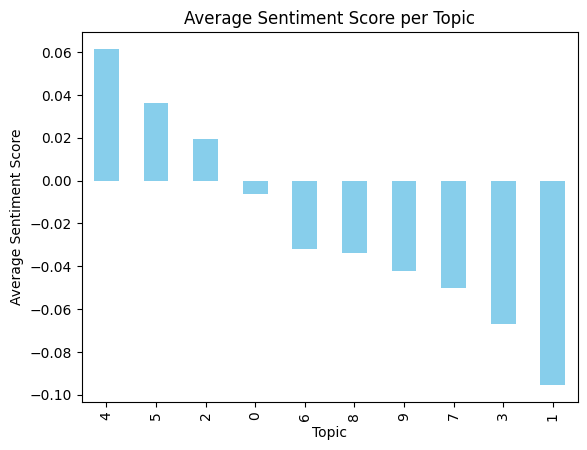

In [39]:
# Next, we calculate the average sentiment score for each topic
# Suppose we already have a column 'Sentiment_Score' in our DataFrame, representing the sentiment score
topic_sentiment = df.groupby('Dominant_Topic')['TextBlob Sentiment'].mean().sort_values(ascending=False)

# Visualize the average sentiment score for each topic
topic_sentiment.plot(kind='bar', color='skyblue')
plt.title('Average Sentiment Score per Topic')
plt.xlabel('Topic')
plt.ylabel('Average Sentiment Score')
plt.show()

N-gram

In [40]:
def get_top_ngram(corpus, n):
    lis=[]
    vec = CountVectorizer(ngram_range = (n,n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0)
    for word,idx in vec.vocabulary_.items():
        lis.append((word, sum_words[0,idx]))
    lis.sort(key = lambda x: x[1], reverse = True)
    return lis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: title={'center': 'Top 20 frequently occured uni-gram'}>

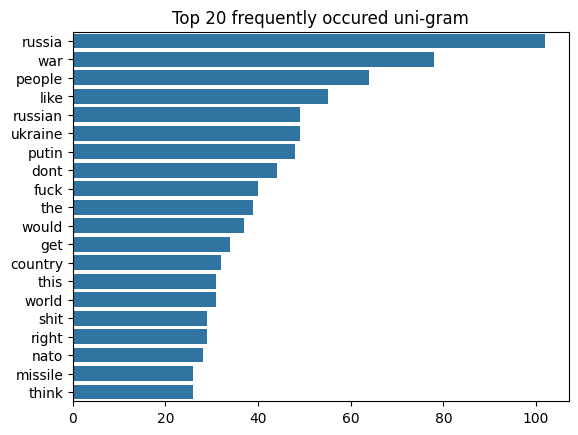

In [41]:
top_n_bigrams=get_top_ngram(df['Processed body'],1)[:20]
x,y=map(list,zip(*top_n_bigrams))
plt.title('Top 20 frequently occured uni-gram')
sns.barplot(x=y,y=x)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: title={'center': 'Top 20 frequently occured bi-grams'}>

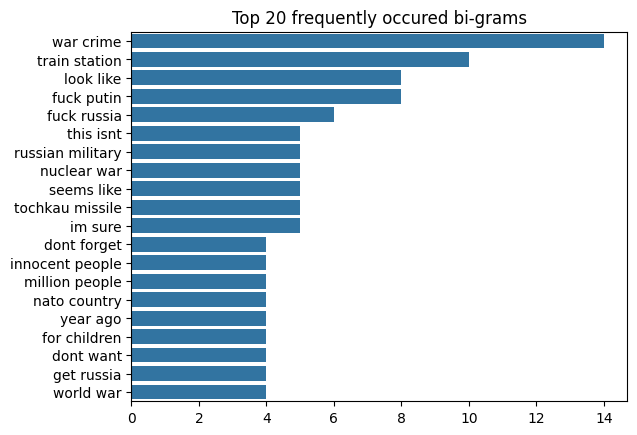

In [42]:
top_n_bigrams=get_top_ngram(df['Processed body'],2)[:20]
x,y=map(list,zip(*top_n_bigrams))
plt.title('Top 20 frequently occured bi-grams')
sns.barplot(x=y,y=x)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: title={'center': 'Top 20 frequently occured tri-grams'}>

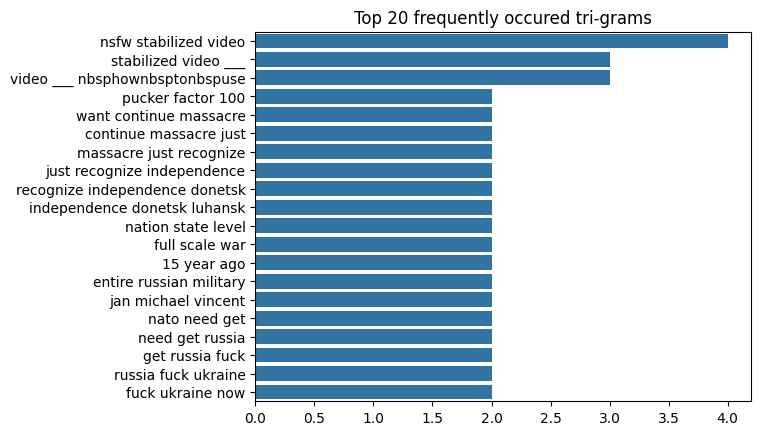

In [43]:
top_n_bigrams=get_top_ngram(df['Processed body'],3)[:20]
x,y=map(list,zip(*top_n_bigrams))
plt.title('Top 20 frequently occured tri-grams')
sns.barplot(x=y,y=x)

Visualisation

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


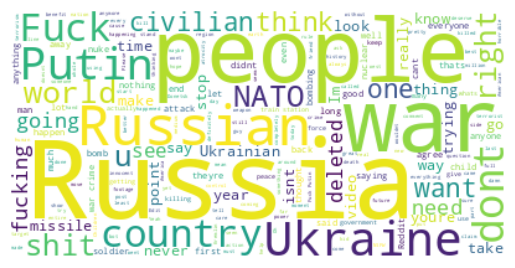

In [44]:
# WordCloud
text = ' '.join(review for review in df['Processed body'])
wordcloud = WordCloud(background_color='white').generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()